<a href="https://colab.research.google.com/github/diss03/Deep-Learning/blob/chest_pneumonia_classification/Chest_pneumonia_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [200]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="EPyw8ZneZwTdYCduVkyz")
project = rf.workspace("poom-test").project("chest-x-ray-classify")
version = project.version(3)
dataset = version.download("multiclass")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to chest-x-ray-classify-3 in multiclass:: 100%|██████████| 4853/4853 [00:03<00:00, 1365.16it/s]


In [201]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid

In [202]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [203]:
datadir='/content/sample_data/chest-x-ray-classify-3'
traindir='/content/sample_data/chest-x-ray-classify-3/train'
testdir='/content/sample_data/chest-x-ray-classify-3/test'
valdir='/content/sample_data/chest-x-ray-classify-3/valid'

In [235]:
train_transform = v2.Compose([v2.Resize([224,224]),
                              v2.ToImage(),   v2.ToDtype(torch.float32, scale=True)])
transform = v2.Compose([v2.Resize([224,224]), v2.ToImage(),
                        v2.ToDtype(torch.float32, scale=True)])

Расположим все изображения по папкам классов:

In [205]:
import pandas as pd
import os
import shutil

In [206]:
def create_directories(df, main_dir):
  class_dirs = df.columns[1:]
  # Создание классовых папок, если они не существуют
  for i in range(len(class_dirs)):
      class_dir_path = os.path.join(main_dir, class_dirs[i])
      if not os.path.exists(class_dir_path):
          os.makedirs(class_dir_path)

In [209]:
df = pd.read_csv("/content/sample_data/chest-x-ray-classify-3/valid/_classes.csv")
create_directories(df, traindir)
create_directories(df, testdir)
create_directories(df, valdir)

In [210]:
def move_file(main_dir, df):
    columns_name = list(df.columns[1:])
    for index, row in df.iterrows():
        file_name = row[0]
        for i in range(len(columns_name)):
            if(row[i+1]==1):
                class_dir_path = os.path.join(main_dir, columns_name[i])
                file_path = os.path.join(main_dir, file_name)
                if os.path.exists(file_path):
                    shutil.move(file_path, os.path.join(class_dir_path, file_name))

In [211]:
df = pd.read_csv("/content/sample_data/chest-x-ray-classify-3/train/_classes.csv")
move_file(traindir, df)

df = pd.read_csv("/content/sample_data/chest-x-ray-classify-3/test/_classes.csv")
move_file(testdir, df)

df = pd.read_csv("/content/sample_data/chest-x-ray-classify-3/valid/_classes.csv")
move_file(valdir, df)

In [236]:
train_dataset=datasets.ImageFolder(traindir,transform=train_transform)
test_dataset=datasets.ImageFolder(testdir,transform=transform)
val_dataset=datasets.ImageFolder(valdir,transform=transform)

In [213]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

In [237]:
lb=train_dataset.targets
lb=np.array(lb)
np.unique(lb,return_counts=True)

(array([0, 1]), array([2130, 2109]))

In [238]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

torch.Size([32, 3, 224, 224])


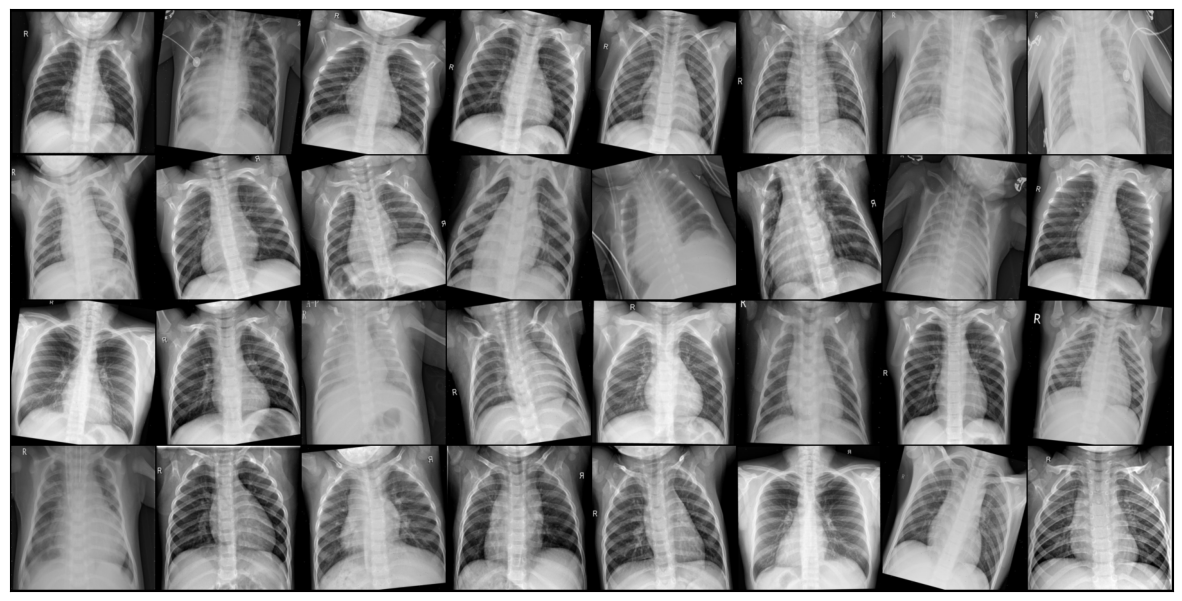

In [239]:
show_batch(train_loader)

torch.Size([32, 3, 224, 224])


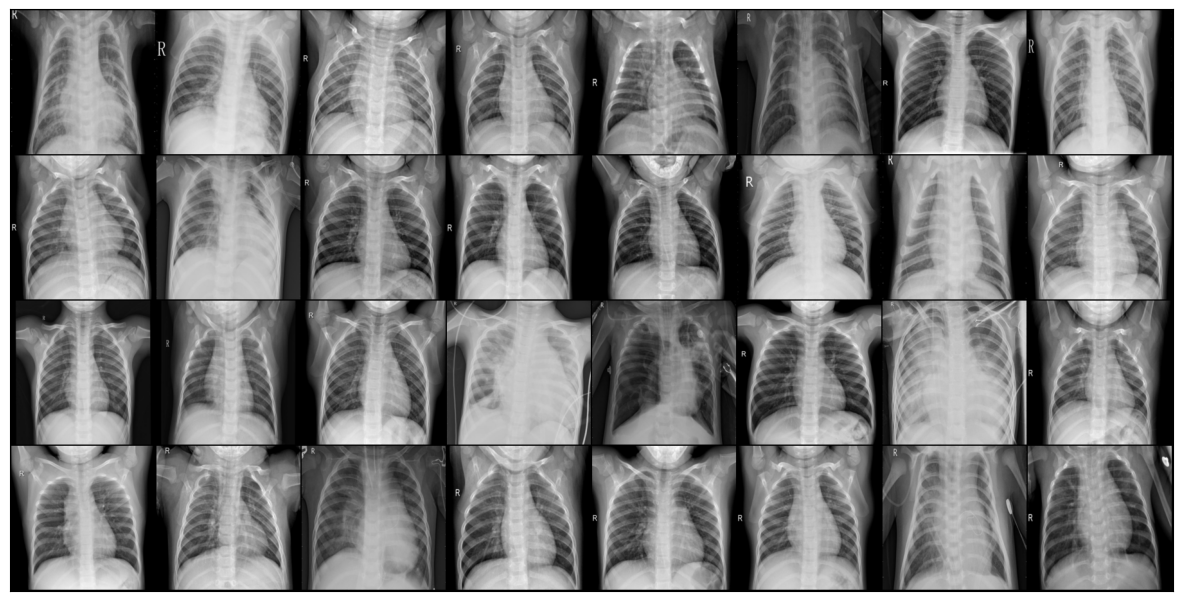

In [240]:
show_batch(test_loader)

Описание модели:


In [225]:
! pip install efficientnet_pytorch

In [241]:
import torchvision.models as models
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')
model.to(device);

In [227]:
! pip install torchinfo

In [262]:
from torchinfo import summary
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 2]                    --
├─Sequential: 1-1                                  [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         64
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         896
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           5,136
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6   

In [229]:
num_classes=len(train_dataset.classes)

num_input_channels = 1
model.features[0][0] = nn.Conv2d(num_input_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# Добавление копирования каналов для преобразования одноканальных изображений в трехканальные
class ConvertToThreeChannels(nn.Module):
    def forward(self, x):
        return torch.cat([x, x, x], dim=1)
# Создание экземпляра класса для преобразования каналов
convert_to_three_channels = ConvertToThreeChannels()
# Объединение модели с преобразованием входного изображения
model = nn.Sequential(convert_to_three_channels, model)

In [230]:
model.to(device);

In [243]:
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
model.to(device);

In [245]:
summary(model,input_size=(32,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [32, 2]                   --
├─Sequential: 1-1                                  [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                   [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                            [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        64
│    │    └─ReLU6: 3-3                             [32, 32, 112, 112]        --
│    └─InvertedResidual: 2-2                       [32, 16, 112, 112]        --
│    │    └─Sequential: 3-4                        [32, 16, 112, 112]        896
│    └─InvertedResidual: 2-3                       [32, 24, 56, 56]          --
│    │    └─Sequential: 3-5                        [32, 24, 56, 56]          5,136
│    └─InvertedResidual: 2-4                       [32, 24, 56, 56]          --
│    │    └─Sequential: 3-6   

In [270]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0,3.0]).to(device))

In [271]:
!pip install pytorch-ignite --quiet

In [272]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [273]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [274]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=num_classes)}

In [275]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [276]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [277]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [278]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(val_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [279]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [280]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [281]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [282]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 52.63 Сред. ошибка: 0.78817
Результат валидации - Эпоха: 1  Сред. точность: 52.97 Сред. ошибка: 0.77538


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 94.29 Сред. ошибка: 0.09418
Результат валидации - Эпоха: 2  Сред. точность: 87.38 Сред. ошибка: 0.22303


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 97.19 Сред. ошибка: 0.04821
Результат валидации - Эпоха: 3  Сред. точность: 92.33 Сред. ошибка: 0.32455


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 97.24 Сред. ошибка: 0.05677
Результат валидации - Эпоха: 4  Сред. точность: 93.07 Сред. ошибка: 0.41348


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 97.43 Сред. ошибка: 0.04493
Результат валидации - Эпоха: 5  Сред. точность: 93.07 Сред. ошибка: 0.36048


State:
	iteration: 665
	epoch: 5
	epoch_length: 133
	max_epochs: 5
	output: 0.02140255831182003
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

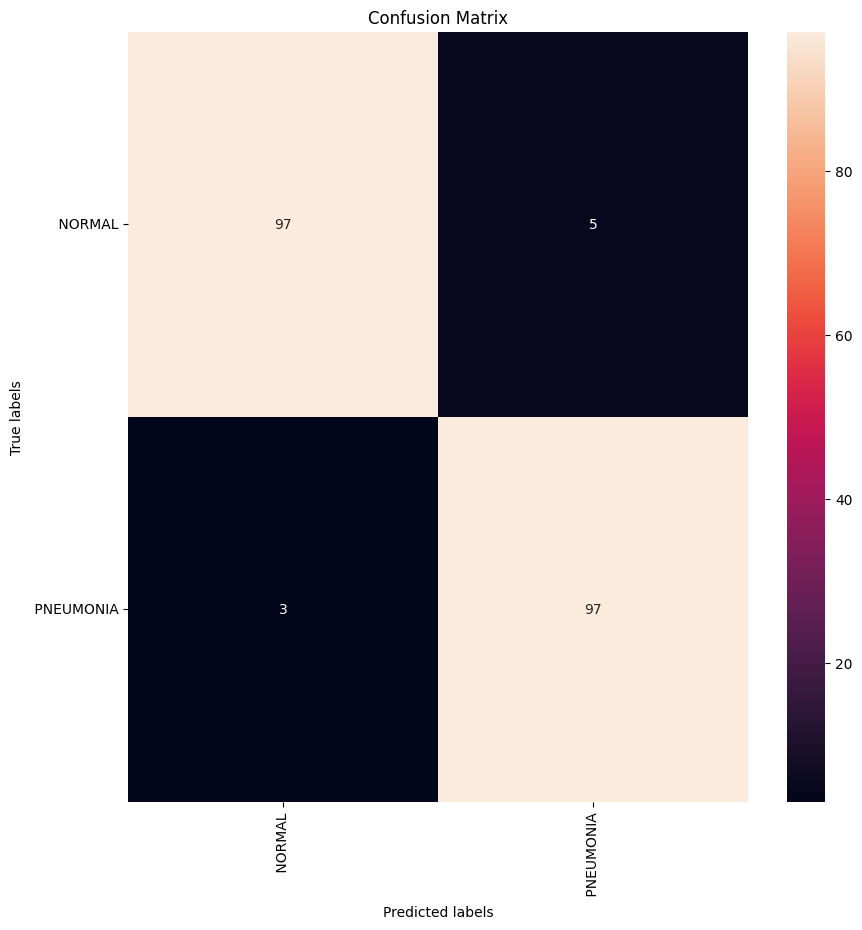

In [283]:
trainer.run(train_loader, max_epochs=5)